In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score


from mlxtend.feature_selection import SequentialFeatureSelector as SFS


In [76]:
X_train_1 =pd.read_csv("../data/X_train_part1.csv", index_col = "index")
X_train_2 =pd.read_csv("../data/X_train_part2.csv", index_col = "index")
X_train_3 =pd.read_csv("../data/X_train_part3.csv", index_col = "index")
X_train = pd.concat([X_train_1,X_train_2,X_train_3])
y_train = pd.read_csv("../data/y_train.csv", index_col = "index")

X_test =pd.read_csv("../data/X_test.csv", index_col = "index")
y_test = pd.read_csv("../data/y_test.csv", index_col = "index")

X_train_removed = pd.read_csv("../data/X_train_removed.csv",index_col = "index")
X_test_removed = pd.read_csv("../data/X_test_removed.csv",index_col = "index")

# 1. Linear Regression

## 1.1 Modelling

Since linear model does not work with date object, we will remove it for now and save it to X_train_removed and X_test_removed.

In [77]:
# Drop the "month" column after extracting the year
X_train_LR = X_train.drop(columns=["month"])
X_test_LR = X_test.drop(columns=["month"])

# Save the "month" column into X_train_removed and X_test_removed
X_train_removed[['month']] = X_train[['month']]
X_test_removed[['month']] = X_test[['month']]

In [78]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_LR, y_train)

LinearRegression()

In [79]:
# examine the coefficients
features = model.feature_names_in_
coefficient = model.coef_
flattened_coefficients = coefficient.flatten()


coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': flattened_coefficients
})

print(coefficients_df)

              Feature    Coefficient
0           flat_type   17213.359984
1      floor_area_sqm    2555.686757
2     remaining_lease   -5260.825891
3        lower_storey  -44867.141738
4        upper_storey   52425.977067
5  flat_model_encoded   36369.749058
6        town_encoded  267703.166028


## 1.2 Evaluation

In [80]:
# Make predictions on the training set
train_pred_LR = model.predict(X_train_LR)

# Calculate training performance metrics
train_rmse = root_mean_squared_error(y_train, train_pred_LR)
train_r2 = r2_score(y_train, train_pred_LR)

print(f"Training RMSE for model 1: {train_rmse}")
print(f"Training R2 Score for model 1: {train_r2}")

Training RMSE for model 1: 120992.11217670405
Training R2 Score for model 1: 0.510174970989081


The R2 score of training set is rather low of only 0.51, meaning that only 51% of the variance is explained by the model.

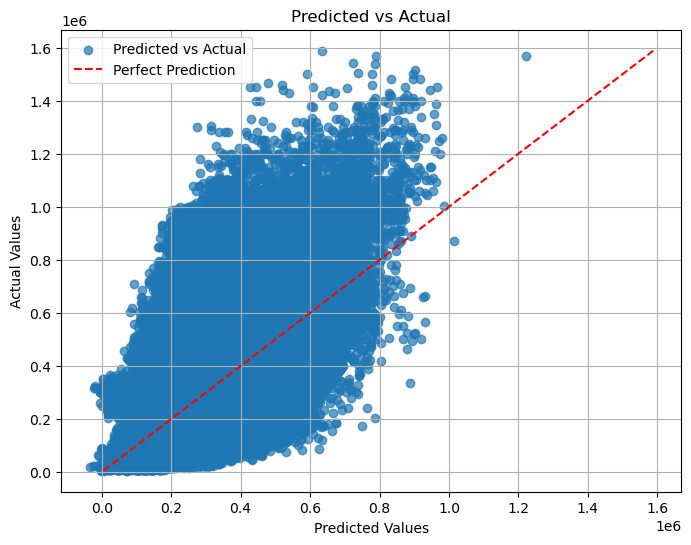

In [81]:
plt.figure(figsize=(8, 6))
plt.scatter(train_pred_LR, y_train, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(True)
plt.legend()
plt.show()

From the residual plot, although we can see a general trend is present, the spread is too high. In particular, in the low and medium region, the model may not be able to predict well enough. This indicates that the model may be underfitting. Additional feature may be needed. 

In [82]:
# Make predictions on the test set
test_pred_LR = model.predict(X_test_LR)

# Calculate test performance metrics
test_rmse = root_mean_squared_error(y_test, test_pred_LR)
test_r2 = r2_score(y_test, test_pred_LR)

print(f"Test RMSE for model 1: {test_rmse}")
print(f"Test R2 Score for model 1: {test_r2}")

Test RMSE for model 1: 121093.08723619273
Test R2 Score for model 1: 0.5114132667419273


The R2 score and RMSE of the test set did not differ much from the train set, meaning that there is no overfitting. This is somewhat expected as the model is simple, less prone to overfitting. However, the poor performance persist.

## 1.3 Adding more feature to make it more complex

From the above analysis, we believe that the model is underfitting. Therefore, we will examing the features we did not make use of to improve the performance.

In [83]:
X_train_removed.columns

Index(['flat_model', 'town', 'region', 'max_storey', 'block', 'street_name',
       'month'],
      dtype='object')

We can try to incorporate time information by extracting year from the month column

In [84]:
# Extract the year from the 'month' column in X_train_removed and X_test_removed
X_train_LR['year'] = pd.to_datetime(X_train_removed['month']).dt.year
X_test_LR['year'] = pd.to_datetime(X_test_removed['month']).dt.year

#### Retraining the model

In [85]:
model_2 = LinearRegression()
model_2.fit(X_train_LR, y_train)

test_pred_LR_2 = model_2.predict(X_test_LR)

test_rmse_2 = root_mean_squared_error(y_test, test_pred_LR_2)
test_r2_2 = r2_score(y_test, test_pred_LR_2)

print(f"Test RMSE for model 2: {test_rmse_2}")
print(f"Test R2 Score for model 2: {test_r2_2}")

Test RMSE for model 2: 83927.95587951364
Test R2 Score for model 2: 0.7652982874225982


We can see that the both R2 improved drastically to 0.76 and RMSE is reduced to 83927. This suggest that `year` is a very informative feature in predicting resale price.

However, R2 can be inflated by simply adding more features. Therefore, we will use adjusted R2 to measure the performance which takes into account the number of features used.

In [86]:
def adjusted_r2(r2, X, y):
    """
    Calculate Adjusted R² given R², feature matrix, and target values.

    Parameters:
    - r2 (float): R² score of the model.
    - X (pd.DataFrame or np.ndarray): Feature matrix (used to determine number of predictors).
    - y (pd.Series or np.ndarray): Target variable (used to determine number of observations).

    Returns:
    - float: Adjusted R² score.
    """
    # Number of observations and predictors
    n = len(y)  # Number of rows (observations)
    p = X.shape[1]  # Number of columns (predictors)

    # Calculate Adjusted R²
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

In [87]:
test_adjusted_r2 = adjusted_r2(test_r2, X_test_LR, y_test)
test_adjusted_r2_2 = adjusted_r2(test_r2_2, X_test_LR, y_test)


print(f"Test Adjusted R2 Score for model 1: {test_adjusted_r2}")
print(f"Test Adjusted R2 Score for model 2: {test_adjusted_r2_2}")

Test Adjusted R2 Score for model 1: 0.5113923328430324
Test Adjusted R2 Score for model 2: 0.7652882314354272


From adjusted R2 score, we can see that the model indeed improves significantly by adding in the new feature `year`. 

We will then try to visualise the predicted vs actual to see if there is any other trends

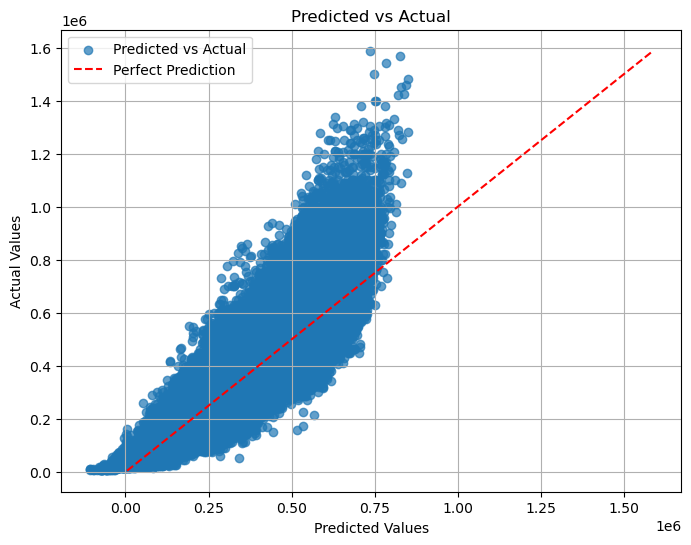

In [88]:
plt.figure(figsize=(8, 6))
plt.scatter(test_pred_LR_2, y_test, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(True)
plt.legend()
plt.show()

The curvature in the scatter plot suggest that the relationship may be non-linear. We may need to apply transformation. As for adding more features, we will automate the process by using forward and backward selection in **section 2**. For now, we will first examine the feature-target relationship.

In addition, the spread around the diagonal line is not uniform, indicating heteroscedasticity. 

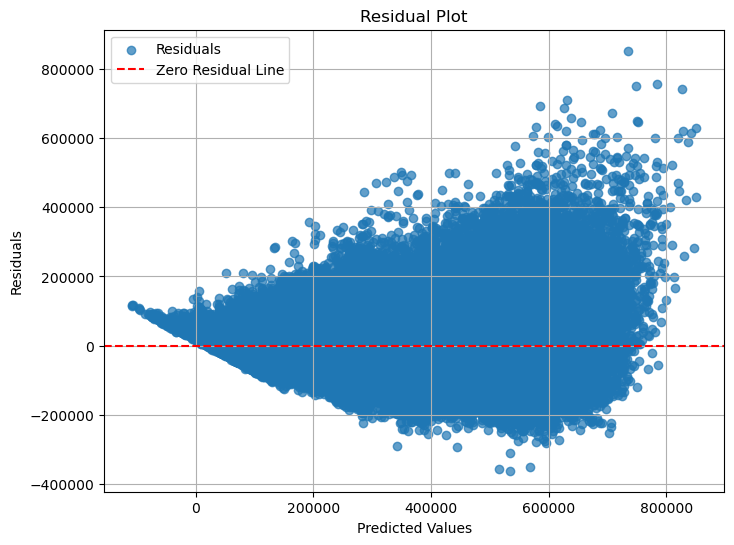

In [89]:
residuals = y_test - test_pred_LR_2

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(test_pred_LR_2, residuals, alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

1. **Purpose of the Residual Plot**:
   - A residual plot is used to assess the fit of a regression model by analyzing the residuals (differences between observed and predicted values).

2. **Key Observations**:
   - **Curved Pattern**:
     - The residuals show a somewhat curved pattern, indicating that the model is failing to capture the nonlinear relationship between the predictors and the target variable.
   - **Heteroscedasticity**:
     - The residuals appear to fan out as the predicted values increase. This indicates heteroscedasticity (non-constant variance of residuals), violating one of the key assumptions of linear regression.
  
https://www.geeksforgeeks.org/residual-analysis/


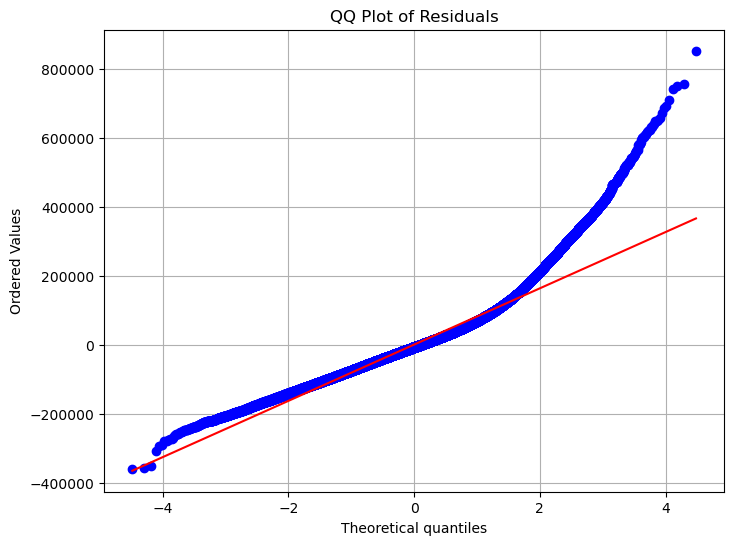

In [90]:
# QQ plot of residuals
residuals = (y_test.squeeze() - test_pred_LR_2.squeeze())
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.show()

1. **Purpose of the QQ Plot**:
      - The QQ plot is used to evaluate whether the residuals from the model follow a normal distribution, which is an assumption in linear regression.
     
2. **Analysis of the Plot**:
      - **Points near the line (Center)**:
        - Residuals in the middle of the distribution (close to 0) are reasonably normal.
      - **Deviations at the tails**:
        - The upper and lower tails deviate significantly from the red line, indicating that the residuals have heavy tails or outliers.
      - **Right Tail**:
        - The steep upward curve indicates the presence of large positive errors (underprediction of large values).
      - **Left Tail**:
        - The downward curve suggests large negative errors (overprediction of small values).

The above 2 plots proves that:
1. The residual is not normally distributed, violating the assumptions of linear model.
2. Variance of residual is not constant.
3. The model may not capture the extreme values effectively.

Hence, the resonable next step is to **apply transformation** to address the non-linearity. In addition, further feature engineering may be required to address the possible correlation between variables such as `flat_area_sqm` and `flat_model` since area may be dependent on the type of flat.

## 1.4 Checking for feature-target relationship

We want to examine if there is non-linear relationship between the feature and the target. If exist, we may conduct transformation to the feature.

### 1.4.1 Numerical

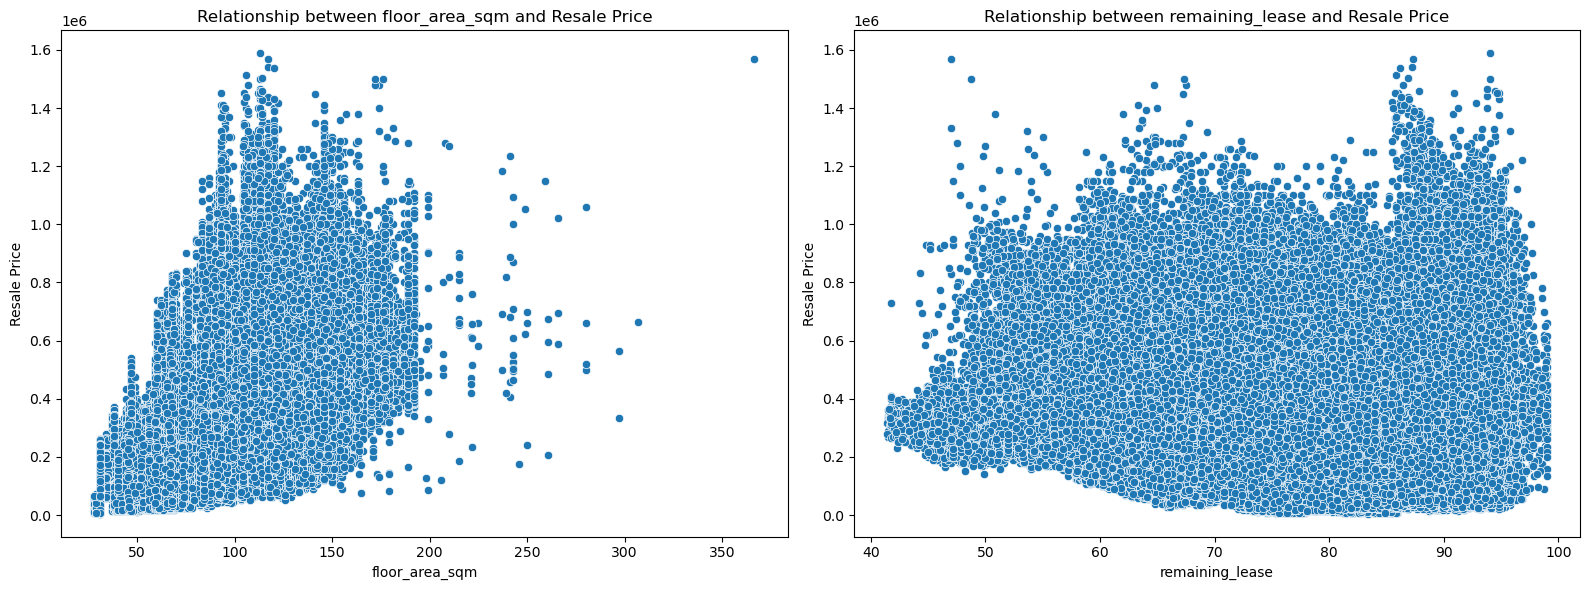

In [91]:
numerical_features = ['floor_area_sqm', 'remaining_lease']
y_train_1d = y_train.squeeze()  

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

for ax, feature in zip(axes, numerical_features):
    sns.scatterplot(data=X_train_LR, x=feature, y=y_train_1d, ax=ax)
    ax.set_title(f'Relationship between {feature} and Resale Price')
    ax.set_xlabel(feature)
    ax.set_ylabel('Resale Price')

plt.tight_layout()
plt.show()

`floor_area_sqm`:
- There seems to be a slight positive relationship (as floor area increases, resale price tends to increase).
- However, there is significant variability in prices for larger floor areas, especially above ~150 sqm.
- This might indicate diminishing returns (e.g., larger units don’t always translate to proportionally higher prices).
- Log-transformation can be applied to see if it improves the result because it is currently right-skewed

`remaining_lease`:
- The relationship appears flat, with no obvious trend.
- Resale prices remain scattered across different lease durations, suggesting that remaining_lease alone may not strongly influence price.

Hence, we should further examing floor_area_sqm

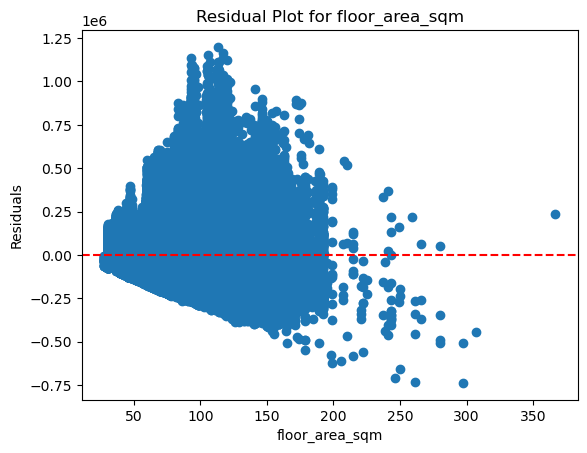

In [92]:
feature = 'floor_area_sqm'
temp_model = LinearRegression()

temp_model.fit(X_train_LR[[feature]], y_train)
pred_temp = temp_model.predict(X_train_LR[[feature]])


residuals = y_train - pred_temp

# Plot residuals
plt.scatter(X_train_LR[feature], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot for {feature}')
plt.xlabel(feature)
plt.ylabel('Residuals')
plt.show()

#### Applying log-transformation to `flat_area_sqm`

We will try to apply log-transformation to see if it improves the result.

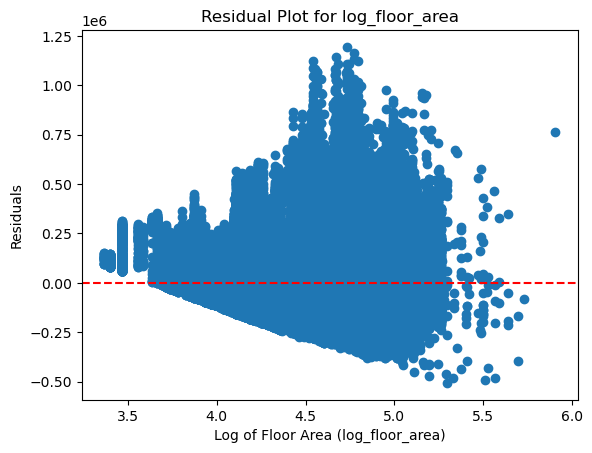

In [93]:
# log transforming
X_train_LR_log_transformed = X_train_LR.copy()
X_train_LR_log_transformed['log_floor_area'] = np.log1p(X_train['floor_area_sqm'])
X_test_LR_log_transformed = X_test_LR.copy()
X_test_LR_log_transformed['log_floor_area'] = np.log1p(X_test['floor_area_sqm'])

model_temp = LinearRegression()
model_temp.fit(X_train_LR_log_transformed[['log_floor_area']], y_train)

pred = model_temp.predict(X_train_LR_log_transformed[['log_floor_area']])
residuals = y_train - pred

# Plot residuals
plt.scatter(X_train_LR_log_transformed['log_floor_area'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for log_floor_area')
plt.xlabel('Log of Floor Area (log_floor_area)')
plt.ylabel('Residuals')
plt.show()

The log transformation slightly improves the spread in the x-axis which is likely due to the effect of log-tranformation. However, it still has the same shape before the transformation in the y-axis.

In [94]:
model_3 = LinearRegression()
model_3.fit(X_train_LR_log_transformed, y_train)

# Make predictions on the test set
test_pred_LR_3 = model_3.predict(X_test_LR_log_transformed)

test_rmse_model_3 = root_mean_squared_error(y_test, test_pred_LR_3)
test_r2_model_3 = r2_score(y_test, test_pred_LR_3)
n_test = X_test_LR_log_transformed.shape[0] 
p_test = X_test_LR_log_transformed.shape[1]  
adjusted_r2_test = adjusted_r2(test_r2_model_3, X_test_LR_log_transformed, test_pred_LR_3)



print(f"Test RMSE for model_3: {test_rmse_model_3}")
print(f"Test R2 for model_3: {test_r2_model_3}")
print(f"Test Adjusted R2 for model_3: {adjusted_r2_test}")

Test RMSE for model_3: 83928.97341749076
Test R2 for model_3: 0.7652925963664763
Test Adjusted R2 for model_3: 0.7652812830460001


The increase is very small, from 0.765288 to 0.765292, suggesting that the non-linearity is unlikely to be caused by floor_area_sqm. Hence, we proceed with applying a transformation to the target variable, as we previously suspected that the target distribution may benefit from stabilization or normalization to improve model performance.

However, some categorical features may need to be recoded.

#### Applying log-transformation to target variable

In [95]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [96]:
# redoing encoding
X_train_LR_log = X_train.drop(columns=['flat_model_encoded', 'town_encoded','month']).copy()
X_test_LR_log = X_test.drop(columns=['flat_model_encoded', 'town_encoded','month']).copy()

X_train_LR_log['flat_model'] = X_train_removed['flat_model']
X_test_LR_log['flat_model'] = X_test_removed['flat_model']

X_train_LR_log['town'] = X_train_removed['town']
X_test_LR_log['town'] = X_test_removed['town']

# Recalculating label encoding for flat_model
train_combined_log = pd.concat([X_train_LR_log, y_train_log], axis=1)
flat_model_mean_log_resale_price = train_combined_log.groupby('flat_model')['resale_price'].mean().reset_index()

scaler = MinMaxScaler(feature_range=(0, 10))
flat_model_mean_log_resale_price['scaled_resale_price'] = scaler.fit_transform(
    flat_model_mean_log_resale_price[['resale_price']]
)
flat_model_mapping_log = flat_model_mean_log_resale_price.set_index('flat_model')['scaled_resale_price'].to_dict()

X_train_LR_log['flat_model_encoded'] = X_train_LR_log['flat_model'].map(flat_model_mapping_log)
X_test_LR_log['flat_model_encoded'] = X_test_LR_log['flat_model'].map(flat_model_mapping_log)


# Recalculating target mean encoding for town
town_target_mean_log = pd.DataFrame({
    'town': X_train_LR_log['town'],
    'resale_price': y_train_log.squeeze()
}).groupby('town')['resale_price'].mean()

X_train_LR_log['town_encoded'] = X_train_LR_log['town'].map(town_target_mean_log)
overall_mean_log_price = y_train_log.mean()
X_test_LR_log['town_encoded'] = X_test_LR_log['town'].map(town_target_mean_log).fillna(overall_mean_log_price)

# Scaling the target-encoded values for town
scaler = MinMaxScaler()
X_train_LR_log['town_encoded'] = scaler.fit_transform(X_train_LR_log[['town_encoded']])
X_test_LR_log['town_encoded'] = scaler.transform(X_test_LR_log[['town_encoded']])

# adding year
X_train_LR_log['year'] = pd.to_datetime(X_train_removed['month']).dt.year
X_test_LR_log['year'] = pd.to_datetime(X_test_removed['month']).dt.year

# dropping processed columns
X_train_LR_log = X_train_LR_log.drop(columns=['flat_model','town'])
X_test_LR_log = X_test_LR_log.drop(columns=['flat_model','town'])


In [97]:
model_4 = LinearRegression()

model_4.fit(X_train_LR_log, y_train_log)

# Make predictions on the test set
test_pred_LR_4 = model_4.predict(X_test_LR_log)

# Calculate training performance metrics
test_rmse_4 = root_mean_squared_error(y_test_log, test_pred_LR_4)
test_r2_4 = r2_score(y_test_log, test_pred_LR_4)

print(f"Testing RMSE for model 4: {test_rmse_4}")
print(f"Testing R2 Score for model 4: {test_r2_4}")

Testing RMSE for model 4: 0.298969561828114
Testing R2 Score for model 4: 0.7641284128200999


Unfortunately, contrary to our expectation, the  R2  score decreased after applying the transformation, suggesting that the transformation may have disrupted the relationship between the predictors and the target. This could indicate that the original target distribution was already well-suited for modeling, or that the assumed benefits of the transformation, such as stabilizing variance or addressing non-linearity, did not align with the true underlying data patterns. As a result, the transformation may have introduced unnecessary complexity, leading to a decline in model performance.

For now, we will make use of model 2's performance to compare with the following models.

Although we suspect there exist non-linear relationship, examming pair-wise relationship can be time-consuming and not worth the time. Hence, we will resort to trying out non-parametric regression, KNN regression, which does not have any assumption about linearity in section 3.

# 2. Forward and Backward selection

From the above analysis, some features may not contribute significantly to the predictive power of the model due to the violation of assumption(Linearity, homoscedasticity) while some very useful features are left out. To address this, we will use both the forward and back selection method to systematically choose the appropriate set of predictors and then compare the values.

#### Data cleaning and encoding newly added categorical variables

Since the model is underfitting, we will now add all previously left out features to be a candicate of target features. We will also conduct feature endoing in this section. Features such as street name and block will be coded using mean encoding.

In [98]:
# Step 1: Add newly added features (street_name, region, block) to the datasets
X_train_step = pd.concat([X_train, X_train_removed[['street_name', 'region', 'block']]], axis=1)
X_test_step = pd.concat([X_test, X_test_removed[['street_name', 'region', 'block']]], axis=1)

# Step 2: Mean encoding for the newly added features
# Add resale_price to X_train_step temporarily to calculate the means
X_train_step = pd.concat([X_train_step, y_train], axis=1)

# Encode `street_name`
street_name_mean_target = X_train_step.groupby('street_name')['resale_price'].mean()
X_train_step['street_name_encoded'] = X_train_step['street_name'].map(street_name_mean_target)
X_test_step['street_name_encoded'] = X_test_step['street_name'].map(street_name_mean_target).fillna(y_train.mean())

# Encode `region`
region_mean_target = X_train_step.groupby('region')['resale_price'].mean()
X_train_step['region_encoded'] = X_train_step['region'].map(region_mean_target)
X_test_step['region_encoded'] = X_test_step['region'].map(region_mean_target).fillna(y_train.mean())

# Encode `block`
block_mean_target = X_train_step.groupby('block')['resale_price'].mean()
X_train_step['block_encoded'] = X_train_step['block'].map(block_mean_target)
X_test_step['block_encoded'] = X_test_step['block'].map(block_mean_target).fillna(y_train.mean())

# Step 3: Drop the original categorical columns after encoding
X_train_step = X_train_step.drop(columns=['street_name', 'region', 'block','resale_price'])
X_test_step = X_test_step.drop(columns=['street_name', 'region', 'block'])

#### Adding more possible features

Extracting `year` and `month`from the current `month` feature

In [99]:
X_train_step['year'] = pd.to_datetime(X_train['month']).dt.year
X_test_step['year'] = pd.to_datetime(X_test['month']).dt.year

X_train_step['month_num'] = pd.to_datetime(X_train['month']).dt.month
X_test_step['month_num'] = pd.to_datetime(X_test['month']).dt.month

X_train_step = X_train_step.drop(columns=['month'])
X_test_step = X_test_step.drop(columns=['month'])

#### Fowward selection

We will make use of the SequentialFeatureSelector from the mlextend package. The function SFS will do the selection of features first and then, we will simply use the selected features to build the model.

In [100]:
model_forward = LinearRegression()

# Configure Sequential Feature Selector for forward selection
sfs_forward = SFS(
    model_forward,
    k_features='best',  # Automatically find the best number of features
    forward=True,       # Enable forward selection
    floating=False,     # Disable floating (strict forward selection)
    scoring='r2',       # Use R^2 as the scoring metric
    cv=10               # Use 10-fold cross-validation
)

# Fit the selector on the training data
sfs_forward = sfs_forward.fit(X_train_step, y_train)


In [102]:
# Get the selected features
selected_features_forward = list(sfs_forward.k_feature_names_)
print("Selected Features (Forward Selection):", selected_features_forward)

Selected Features (Forward Selection): ['flat_type', 'floor_area_sqm', 'remaining_lease', 'lower_storey', 'upper_storey', 'flat_model_encoded', 'town_encoded', 'street_name_encoded', 'region_encoded', 'block_encoded', 'year', 'month_num']


All features are selected. 

In [103]:
# Train the model
model_forward.fit(X_train_step, y_train)

# Predictions
train_pred_forward = model_forward.predict(X_train_step)
test_pred_forward = model_forward.predict(X_test_step)

# Calculate metrics
train_rmse_forward = root_mean_squared_error(y_train, train_pred_forward)
test_rmse_forward = root_mean_squared_error(y_test, test_pred_forward)

r2_train_forward = r2_score(y_train, train_pred_forward)
r2_test_forward = r2_score(y_test, test_pred_forward)

adjusted_r2_train_forward = adjusted_r2(r2_train_forward, X_train_step, y_train)
adjusted_r2_test_forward = adjusted_r2(r2_test_forward, X_test_step, y_test)

print("### Forward Selection ###")
print(f"Train RMSE: {train_rmse_forward}")
print(f"Test RMSE: {test_rmse_forward}")
print(f"Train R2: {r2_train_forward}")
print(f"Test R2: {r2_test_forward}")
print(f"Train Adjusted R2: {adjusted_r2_train_forward}")
print(f"Test Adjusted R2: {adjusted_r2_test_forward}")

### Forward Selection ###
Train RMSE: 75894.313189523
Test RMSE: 75953.75445997805
Train R2: 0.8072717728410154
Test R2: 0.8077787222888739
Train Adjusted R2: 0.8072686763326782
Test Adjusted R2: 0.8077663682070124


#### Backward selection

In [104]:
model_backward = LinearRegression()

sfs_backward = SFS(
    model_backward,
    k_features='best',  # Automatically find the best number of features
    forward=False,      # Enable backward elimination
    floating=False,     # Disable floating (strict backward elimination)
    scoring='r2',       # Use R^2 as the scoring metric
    cv=10               # Use 10-fold cross-validation
)

# Fit the selector on the training data
sfs_backward = sfs_backward.fit(X_train_step, y_train)

In [105]:
# Get the selected features
selected_features_backward = list(sfs_backward.k_feature_names_)
print("Selected Features (Backward Elimination):", selected_features_backward)

Selected Features (Backward Elimination): ['flat_type', 'floor_area_sqm', 'remaining_lease', 'lower_storey', 'upper_storey', 'flat_model_encoded', 'town_encoded', 'street_name_encoded', 'region_encoded', 'block_encoded', 'year', 'month_num']


All 12 features are chosen too. Both the r2 and rmse score of model_forward improved as compared to model 3, indicating a better performance. In addtion, the test and train performance did not vary much, indicating that there is no over-fitting although all features are chosen.

# 3. KNN regression

In the section 1.4, we see that there are some serious violation of the assumptions of linearity and the homoscedasticity. Hence we will make use of KNN regression which is non-parametric and does not make any assumptions about the data.

## 3.1 Data cleaing

Scaling of features are required as KNN is dependent on distance metrics.

In [113]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled_array = scaler.fit_transform(X_train_step)
X_test_scaled_array = scaler.transform(X_test_step)

# Convert the scaled data back to a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train_step.columns, index=X_train_step.index)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test_step.columns, index=X_test_step.index)

# Display the first few rows of the scaled DataFrame to verify
print(X_train_scaled.head())

        flat_type  floor_area_sqm  remaining_lease  lower_storey  \
index                                                              
21935    0.333333        0.132861         0.864583        0.0625   
82906    0.666667        0.304104         0.791667        0.1875   
833379   0.500000        0.188958         0.857639        0.0625   
49991    0.333333        0.109241         0.777778        0.0000   
379757   0.333333        0.115146         0.677083        0.1250   

        upper_storey  flat_model_encoded  town_encoded  street_name_encoded  \
index                                                                         
21935         0.0625            0.130519      0.516596             0.261014   
82906         0.1875            0.130519      0.607684             0.224780   
833379        0.0625            0.130519      1.000000             0.435788   
49991         0.0000            0.127953      0.663174             0.185722   
379757        0.1250            0.000000      0.6

## Feature selection

Distance metrics breaks down in high dimension. Hence, we would like to examine if there is any problem with the dimension by plotting a histogram of euclidean distance.

In [68]:
# Randomly select a subset of indices for visualization
subset_size = 10000  
random_indices = np.random.choice(X_train_scaled.shape[0], size=subset_size, replace=False)
subset = X_train_scaled[random_indices]

pairwise_dists = pairwise_distances(subset)

# Normalize distances by the maximum distance
max_distance = np.max(pairwise_dists)
normalized_dists = pairwise_dists / max_distance

# Extract the upper triangle (excluding diagonal)
upper_triangle_dists = normalized_dists[np.triu_indices_from(pairwise_dists, k=1)]

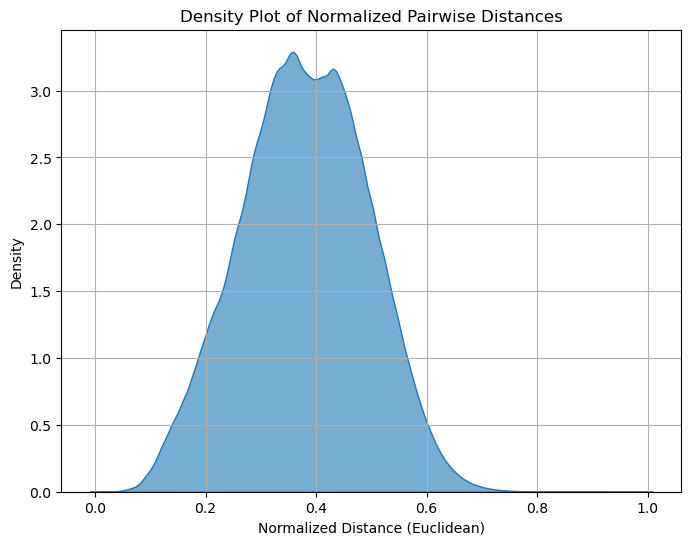

In [69]:
plt.figure(figsize=(8, 6))
sns.kdeplot(upper_triangle_dists, fill=True, alpha=0.6)
plt.title('Density Plot of Normalized Pairwise Distances')
plt.xlabel('Normalized Distance (Euclidean)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

We can see that the pair-wise distance seems to form a normal distribution which is not very bad (if it is bad, then it should be all clutered at a very thin strip). However, we may still want to examine if we can reduce the number of features used because by reducing the less informative features, the inference and training process will speed up and it is also possible that the performance will increse.

#### Wrapper Method: Custom Implementation for KNN (Forward Selection)

1. **Initial Setup**:
   - Start with an empty feature set.

2. **Evaluation**:
   - At each iteration, add one feature at a time from the remaining pool.
   - Train the KNN model on the new subset and use cross-validation to calculate the R2 score for each subset.

3. **Selection**:
   - Identify and add the most impactful feature (highest R2 score).

4. **Stopping**:
   - Repeat the process until all features are included.

5. **Visualization**:
   - Plot the cross-validated performance against the number of features to identify the optimal subset.

However, it is expected that the process will take a very long time. Since we want to get the most accurate result, we will not subset the data but let it run on the entire dataset.

In [71]:
knn_model = KNeighborsRegressor(n_neighbors=5)


In [72]:
# Custom Feature selection
selected_features = []  # Start with no features
remaining_features = list(range(X_train_scaled.shape[1]))  # All feature indices
subset_performance = []  # Store R2 scores for each step

while remaining_features:
    performance_with_new_feature = []
    
    # Test adding each remaining feature
    for feature in remaining_features:
        current_features = selected_features + [feature]
        cv_scores = cross_val_score(knn_model, X_train_scaled[:, current_features], y_train, cv=10, scoring='r2')
        performance_with_new_feature.append(np.mean(cv_scores))
    
    # Find the best feature to add
    best_new_feature_index = np.argmax(performance_with_new_feature)
    best_new_feature = remaining_features[best_new_feature_index]
    best_performance = performance_with_new_feature[best_new_feature_index]
    
    # Update selected and remaining features
    selected_features.append(best_new_feature)
    remaining_features.remove(best_new_feature)
    subset_performance.append(best_performance)
    
    print(f"Step {len(selected_features)}: Added feature {best_new_feature}, R2 = {best_performance:.4f}")
    

Step 1: Added feature 10, R2 = 0.4384
Step 2: Added feature 1, R2 = 0.8097
Step 3: Added feature 7, R2 = 0.9411
Step 4: Added feature 6, R2 = 0.9621
Step 5: Added feature 2, R2 = 0.9711
Step 6: Added feature 8, R2 = 0.9750
Step 7: Added feature 5, R2 = 0.9757
Step 8: Added feature 0, R2 = 0.9762
Step 9: Added feature 9, R2 = 0.9741
Step 10: Added feature 3, R2 = 0.9710
Step 11: Added feature 4, R2 = 0.9687
Step 12: Added feature 11, R2 = 0.9491


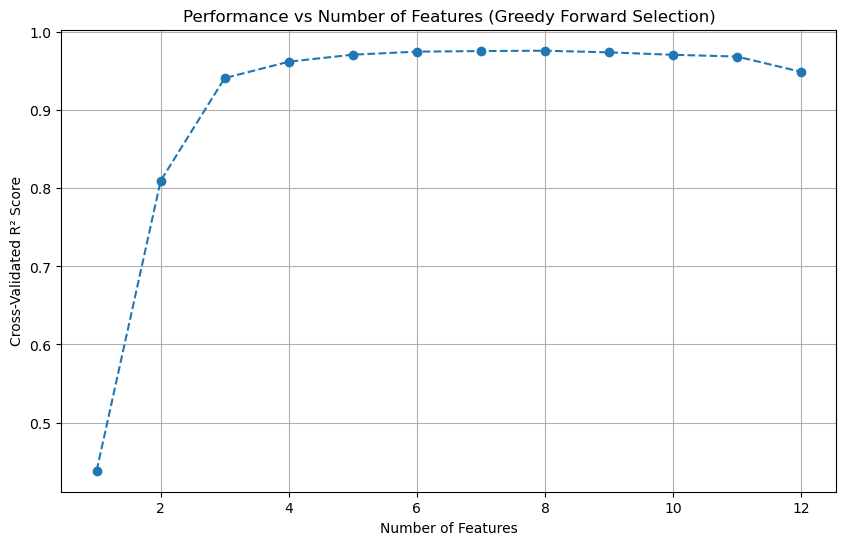

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(subset_performance) + 1), subset_performance, marker='o', linestyle='--')
plt.title('Performance vs Number of Features (Greedy Forward Selection)')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated R² Score')
plt.grid(True)
plt.show()

From the plot, we can see that the model performs resonably well with only 3 features. The increase in performance after that is minor. Using, the elbow method, we would have use the first 3 features. However, since there is still a considerable increase in performance by adding the 4th feature, we will keep the first 4.

In [126]:
# Assuming feature_names contains the original feature names
feature_names = X_train_scaled.columns  # Replace with your actual feature names source

# Extract the first 4 selected feature indices
top_4_feature_indices = selected_features[:4]
X_train_KNN = X_train_scaled.iloc[:, top_4_feature_indices]
X_test_KNN = X_test_scaled.iloc[:,top_4_feature_indices]

X_train_KNN.columns

Index(['year', 'floor_area_sqm', 'street_name_encoded', 'town_encoded'], dtype='object')

## Hyperparameter Tuning

### Comparing different distance metrics and value of K.

#### L2 distance

In [116]:
k_values = range(1, 11)
cv_scores_l2 = []  

for k in k_values:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train_KNN, y_train, cv=10, scoring='r2')
    cv_scores_l2.append(np.mean(scores))

In [117]:
best_k = k_values[np.argmax(cv_scores_l2)]
print("### L2 (Euclidean) Distance Metric ###")
print(f"Best k: {best_k}")
print(f"Best CV R2 Score: {max(cv_scores_l2)}")

### L2 (Euclidean) Distance Metric ###
Best k: 4
Best CV R2 Score: 0.9626664775404208


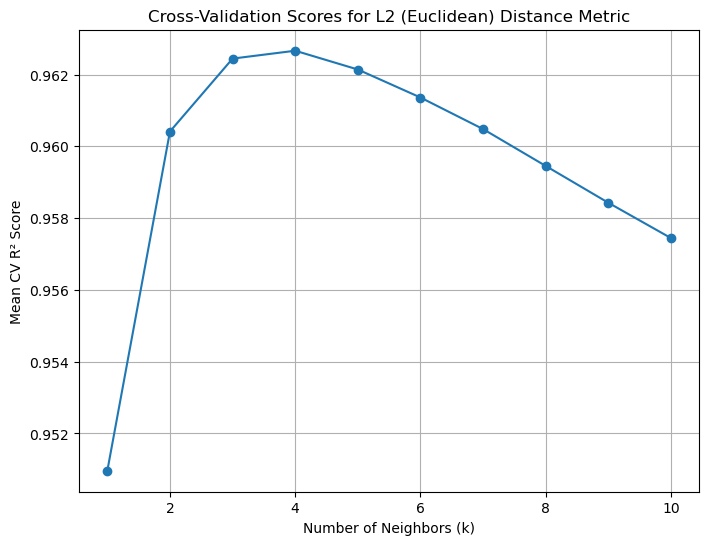

In [118]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, cv_scores_l2, marker='o', linestyle='-')
plt.title('Cross-Validation Scores for L2 (Euclidean) Distance Metric')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV R² Score')
plt.grid(True)
plt.show()

#### L1 distance

In [119]:
cv_scores_l1 = []

for k in range(1, 11):
    knn_model = KNeighborsRegressor(n_neighbors=k, metric='manhattan')
    scores = cross_val_score(knn_model, X_train_KNN, y_train, cv=10, scoring='r2')
    cv_scores_l1.append(np.mean(scores))

In [120]:
# Find the best k for L1
best_k_l1 = np.argmax(cv_scores_l1) + 1 
best_score_l1 = max(cv_scores_l1)

print("### L1 (Manhattan) Distance Metric ###")
print(f"Best k: {best_k_l1}")
print(f"Best CV R2 Score: {best_score_l1}")

### L1 (Manhattan) Distance Metric ###
Best k: 4
Best CV R2 Score: 0.964372983408334


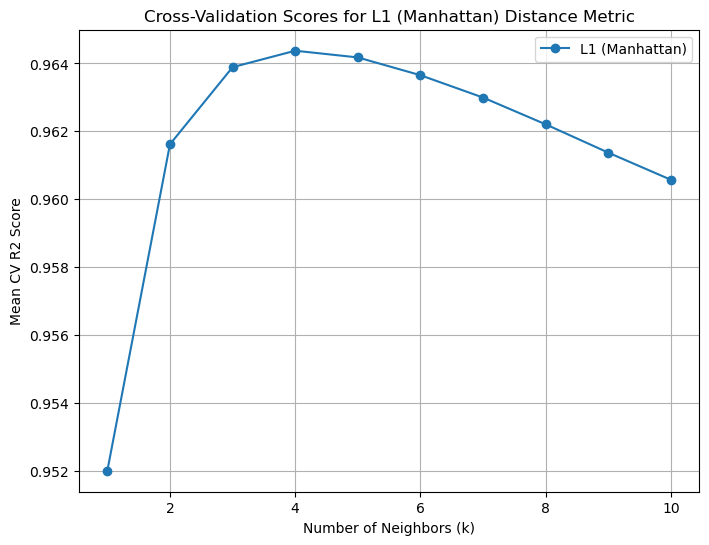

In [121]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), cv_scores_l1, marker='o', label='L1 (Manhattan)')
plt.title('Cross-Validation Scores for L1 (Manhattan) Distance Metric')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV R2 Score')
plt.grid(True)
plt.legend()
plt.show()

### Chebyshev Distance Metric

In [122]:
cv_scores_linfinity = []

for k in range(1, 11):  
    knn_model = KNeighborsRegressor(n_neighbors=k, metric='chebyshev')
    scores = cross_val_score(knn_model, X_train_KNN, y_train, cv=10, scoring='r2')
    cv_scores_linfinity.append(np.mean(scores))

In [123]:
best_k_linfinity = np.argmax(cv_scores_linfinity) + 1 
best_score_linfinity = max(cv_scores_linfinity)

print("### L-infinity (Chebyshev) Distance Metric ###")
print(f"Best k: {best_k_linfinity}")
print(f"Best CV R2 Score: {best_score_linfinity}")

### L-infinity (Chebyshev) Distance Metric ###
Best k: 3
Best CV R2 Score: 0.9611414304637644


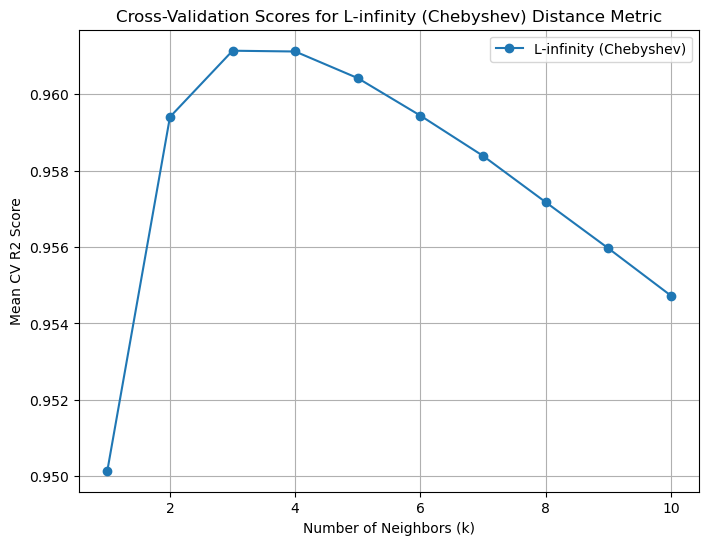

In [124]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), cv_scores_linfinity, marker='o', label='L-infinity (Chebyshev)')
plt.title('Cross-Validation Scores for L-infinity (Chebyshev) Distance Metric')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV R2 Score')
plt.grid(True)
plt.legend()
plt.show()

The KNN using L1 distance achieved the best performance in terms of the mean cross-validation R2 score. Model with L2 did not differ by too much. Hence, we will build 2 model and try them on test dataset.

In [138]:
knn_model_l1 = KNeighborsRegressor(n_neighbors= 4, metric='manhattan')
knn_model_l1.fit(X_train_KNN, y_train)

# Predictions on the training set
train_pred_knn_l1 = knn_model_l1.predict(X_train_KNN)
train_rmse_knn_l1 = root_mean_squared_error(y_train, train_pred_knn_l1)
train_r2_knn_l1 = r2_score(y_train, train_pred_knn_l1)

# Predictions on the test set
test_pred_knn_l1 = knn_model_l1.predict(X_test_KNN)
test_rmse_knn_l1 = root_mean_squared_error(y_test, test_pred_knn_l1)
test_r2_knn_l1 = r2_score(y_test, test_pred_knn_l1)

# Print performance metrics
print(f"Training RMSE KNN l1: {train_rmse_knn_l1}")
print(f"Training R2 KNN l1: {train_r2_knn_l1}")
print(f"Test RMSE KNN l1: {test_rmse_knn_l1}")
print(f"Test R2 KNN l1: {test_r2_knn_l1}")

Training RMSE KNN l1: 27100.18850173308
Training R2 KNN l1: 0.9754262475122757
Test RMSE KNN l1: 32069.24709459508
Test R2 KNN l1: 0.9657326520068953


In [139]:
knn_model_l2 = KNeighborsRegressor(n_neighbors= 4)
knn_model_l2.fit(X_train_KNN, y_train)

# Predictions on the training set
train_pred_knn_l2 = knn_model_l2.predict(X_train_KNN)
train_rmse_knn_l2 = root_mean_squared_error(y_train, train_pred_knn_l2)
train_r2_knn_l2 = r2_score(y_train, train_pred_knn_l2)

# Predictions on the test set
test_pred_knn_l2 = knn_model_l2.predict(X_test_KNN)
test_rmse_knn_l2 = root_mean_squared_error(y_test, test_pred_knn_l2)
test_r2_knn_l2 = r2_score(y_test, test_pred_knn_l2)

# Print performance metrics
print(f"Training RMSE KNN l2: {train_rmse_knn_l2}")
print(f"Training R2 KNN l2: {train_r2_knn_l2}")
print(f"Test RMSE KNN l2: {test_rmse_knn_l2}")
print(f"Test R2 KNN l2: {test_r2_knn_l2}")

Training RMSE KNN l2: 27510.02576207279
Training R2 KNN l2: 0.9746773676085021
Test RMSE KNN l2: 32913.991414150405
Test R2 KNN l2: 0.9639035850742258


model_KNN_l1 is better than model_KNN_l2 in all the performance metrics used, with a lower generalisation error. Hence, we will keep model_KNN_l1.

#### weights
Other than k and distance metrics, we can also try if changing weights == equal to weights == distance will make any changes.

In [134]:
cv_scores_weights_distance = []
k_values = range(1, 21) 

for k in k_values:
    knn_model_distance = KNeighborsRegressor(n_neighbors=k, weights='distance', p = 1)
    scores_distance = cross_val_score(knn_model_distance, X_train_KNN, y_train, cv=10, scoring='r2')
    cv_scores_weights_distance.append(np.mean(scores_distance))



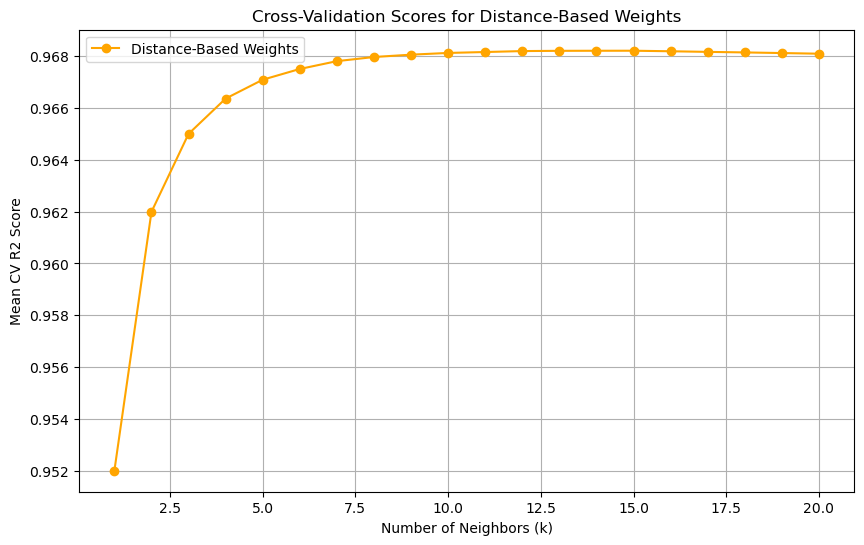

In [135]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores_weights_distance, marker='o', label='Distance-Based Weights', color='orange')
plt.title('Cross-Validation Scores for Distance-Based Weights')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV R2 Score')
plt.legend()
plt.grid(True)
plt.show()

In [136]:
best_k_distance = np.argmax(cv_scores_weights_distance) + 1
best_score_distance = max(cv_scores_weights_distance)

print(f"Best k: {best_k_distance}")
print(f"Best CV R2 Score: {best_score_distance}")
print(f"Best k with Distance-Based Weights: {best_k_distance}")

Best k: 15
Best CV R2 Score: 0.9681935526827641
Best k with Distance-Based Weights: 15


When `weights='distance'`, the performance of the model did not improve and k increases much more(15). Increasing k will slow down the trainning and inference process. Hence, we will still make use of the original model(model_KNN_l1).

In [140]:
print(f"Training RMSE KNN l1: {train_rmse_knn_l1}")
print(f"Training R2 KNN l1: {train_r2_knn_l1}")
print(f"Test RMSE KNN l1: {test_rmse_knn_l1}")
print(f"Test R2 KNN l1: {test_r2_knn_l1}")

Training RMSE KNN l1: 27100.18850173308
Training R2 KNN l1: 0.9754262475122757
Test RMSE KNN l1: 32069.24709459508
Test R2 KNN l1: 0.9657326520068953


The overfitting issue is not severe too. 

# 3. KNN vs Linear Model with Forward Selection

The KNN regression model demonstrates significantly better performance compared to the linear regression model built after forward selection. This improvement is observed in both the **R² score** and **RMSE**, suggesting that KNN can better capture the complex, nonlinear relationships present in the resale price dataset. 

In contrast, the linear regression model struggles due to its reliance on assumptions such as:
1. **Linearity**: The residual plots from the linear model reveal curvature, indicating that the relationships between predictors (e.g., `floor_area_sqm` and `year`) and the target (`resale_price`) are likely nonlinear.
2. **Homoscedasticity**: Residuals from the linear model show non-constant variance, violating another key assumption.

## Why KNN Performs Better
1. **Flexibility**: KNN is non-parametric and makes no assumptions about the underlying data distribution, allowing it to adapt to the nonlinear relationships in the data.
2. **Distance-Based Approach**: KNN uses distance metrics to find similar observations, which is particularly helpful for capturing local patterns, especially in our dataset where features like `block` and `street_name` might introduce locality effects.

## Trade-offs
1. **Training Time**: 
   - KNN computes distances between all points at prediction time, making it slower than linear regression, especially for the large dataset used in this study.
   - While the linear model trains in seconds, KNN's prediction process for a single observation grows linearly with the dataset size.
   
2. **Memory Usage**:
   - KNN requires storing the entire dataset in memory, which can become infeasible for extremely large datasets. 
   - In this case, the resale price dataset is large but manageable due to efficient data scaling and preprocessing.

3. **Interpretability**:
   - Linear regression offers clear coefficients, making it easier to understand the relationship between predictors like `year` and `resale_price`.
   - KNN lacks this interpretability, as it does not provide feature importance, limiting insights into how features like `region` and `flat_type` impact resale prices.

## Dataset-Specific Insights
1. **Year as a Predictor**:
   - In the linear model, `year` significantly improves performance, indicating a strong trend over time.
   - KNN also benefits from `year` since its ability to capture localized patterns can leverage time effects more effectively.

2. **Categorical Features**:
   - Mean encoding for categorical variables like `block` and `street_name` helps both models. However, KNN likely benefits more due to its ability to find neighbors with similar locality (e.g., blocks with similar mean resale prices).

3. **Scale of Features**:
   - Scaling features (e.g., `floor_area_sqm` and `remaining_lease`) was essential for KNN to compute distances effectively. In contrast, linear regression can sometimes tolerate unscaled features but may still benefit from scaling to improve numerical stability.

## Summary of Results
- **KNN**:
   - **Train R²**: Higher, indicating better capture of variance in training data.
   - **Test R²**: Higher than the linear model, suggesting better generalization.
   - **RMSE**: Lower, indicating more accurate predictions.

- **Linear Regression (Forward Selection)**:
   - Faster and more interpretable but fails to capture the underlying nonlinear relationships, as evidenced by the residual analysis.

## Next Steps 
1. **Hybrid Models**:
   - Combine linear models and KNN in an ensemble approach to leverage the strengths of both methods.
   
2. **Model Selection**:
   - Evaluate performance using additional metrics (e.g., Mean Absolute Error) to ensure robustness.
   - Compare KNN against other non-parametric models such as decision trees or random forests.

KNN demonstrates clear advantages for this dataset, providing a strong alternative to linear regression when its assumptions are violated. However, scalability and interpretability challenges must be carefully addressed before deploying KNN in a production environment.